In [7]:
import numpy as np
import math
import itertools
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import norm
from joblib import Parallel, delayed
from itertools import combinations
from scipy.special import comb
import cProfile
from numba import njit, prange
from numba import cuda, float32
import ray
from scipy.integrate import quad
from scipy.special import gamma

# Simulation of the U-Statistic

In [59]:
# U-Statistic is defined as follows for a triplet of draws X, Y, and Z:
# f(X, Y, Z) = sgn(X + Y - 2Z) + sgn(X + Z - 2Y) + sgn(Y + Z - 2X)

# This function will calculate the triples test for skewness provided a triplet of data points
# The argument triplet is a 3x1 vector of sampled variables
def triples_test(data):
    N = len(data)
    triplet = np.array(list(combinations(data, 3)))
    X, Y, Z = triplet[:, 0], triplet[:, 1], triplet[:, 2]
    scalar = (1 / comb(N, 3, exact = True))
    return scalar * np.sum(np.sign(X + Y - 2*Z) + np.sign(X + Z - 2*Y) + np.sign(Y + Z - 2*X))

U_syms1 = []
U_skews1 = []
U_syms2 = []
U_skews2 = []
U_syms3 = []
U_skews3 = []
for n in range(1000):
    vals = [10, 100]
    
    for val in vals:
        normal_draws = np.random.normal(0, 1, val)
        chi_squared_draws = np.random.chisquare(1, val)
        U_sym = triples_test(normal_draws)
        U_skew = triples_test(chi_squared_draws)
        if (val == 10):
            U_syms1.append(U_sym)
            U_skews1.append(U_skew)
        if (val == 100):
            U_syms2.append(U_sym)
            U_skews2.append(U_skew)
        if (val == 500):
            U_syms3.append(U_sym)
            U_skews3.append(U_skew)

KeyboardInterrupt: 

In [2]:
# Parallelized version of the above code

# The triple for loop in this function is the main bottleneck in the code
# Figure out a more computationally efficient algorithm for looping through all possible permutations
# Think about calling the for loop using C code instead of Python code in order to make it more efficient
@njit(parallel=True)
def fast_triples_test(data):
    N = len(data)
    total = 0.0
    for i in prange(N):
        for j in range(i+1, N):
            for k in range(j+1, N):
                X, Y, Z = data[i], data[j], data[k]
                total += np.sign(X + Y - 2*Z) + np.sign(X + Z - 2*Y) + np.sign(Y + Z - 2*X)
    scalar = 1 / (N * (N-1) * (N-2) / 6)
    return scalar * total


def run_iteration(_):
    result = {}
    for val in [10, 100, 1000]:
        normal_draws = np.random.normal(0, 1, val)
        chi_squared_draws = np.random.chisquare(1, val)
        U_sym = fast_triples_test(normal_draws)
        U_skew = fast_triples_test(chi_squared_draws)
        result[val] = {'U_sym': U_sym, 'U_skew': U_skew}
    return result

# Run 1000 iterations in parallel
results = Parallel(n_jobs=-1)(delayed(run_iteration)(i) for i in range(1000))

# Collect results
U_syms1, U_skews1 = [], []
U_syms2, U_skews2 = [], []
U_syms3, U_skews3 = [], []

for res in results:
    U_syms1.append(res[10]['U_sym'])
    U_skews1.append(res[10]['U_skew'])
    U_syms2.append(res[100]['U_sym'])
    U_skews2.append(res[100]['U_skew'])
    U_syms3.append(res[1000]['U_sym'])
    U_skews3.append(res[1000]['U_skew'])

In [16]:
# Even more parallelization compared to the already very parallelized code
# This is in hopes of making p = 10000 computationally feasible
# Even then, after 40 minutes this code still could not finish

@njit(parallel=True)
def fast_triples_test(data):
    N = len(data)
    total = 0.0
    for i in prange(N):
        for j in range(i+1, N):
            for k in range(j+1, N):
                X, Y, Z = data[i], data[j], data[k]
                total += np.sign(X + Y - 2*Z) + np.sign(X + Z - 2*Y) + np.sign(Y + Z - 2*X)
    scalar = 1 / (N * (N-1) * (N-2) / 6)
    return scalar * total

@ray.remote
def run_iteration(_):
    result = {}
    for val in [10, 100, 1000, 10000]:
        normal_draws = np.random.normal(0, 1, val)
        chi_squared_draws = np.random.chisquare(1, val)
        U_sym = fast_triples_test(normal_draws)
        U_skew = fast_triples_test(chi_squared_draws)
        result[val] = {'U_sym': U_sym, 'U_skew': U_skew}
    return result

if __name__ == "__main__":
    ray.shutdown()
    ray.init()  # Start Ray locally; add address= if cluster

    # Launch 1000 Ray tasks asynchronously
    futures = [run_iteration.remote(i) for i in range(1000)]

    # Gather results (waits for all to finish)
    results = ray.get(futures)

    # Collect results into lists
    U_syms1, U_skews1 = [], []
    U_syms2, U_skews2 = [], []
    U_syms3, U_skews3 = [], []
    U_syms4, U_skews4 = [], []

    for res in results:
        U_syms1.append(res[10]['U_sym'])
        U_skews1.append(res[10]['U_skew'])
        U_syms2.append(res[100]['U_sym'])
        U_skews2.append(res[100]['U_skew'])
        U_syms3.append(res[1000]['U_sym'])
        U_skews3.append(res[1000]['U_skew'])
        U_syms4.append(res[10000]['U_sym'])
        U_skews4.append(res[10000]['U_skew'])

    print("Done collecting results!")

2025-05-27 12:04:27,563	INFO worker.py:1888 -- Started a local Ray instance.

KeyboardInterrupt



In [4]:
@njit(inline='always')
def fast_sign(x):
    if x > 0:
        return 1.0
    elif x < 0:
        return -1.0
    else:
        return 0.0

@njit(parallel=True)
def fast_triples_test(data):
    N = data.shape[0]
    total = 0.0
    for i in prange(N):
        for j in range(i+1, N):
            for k in range(j+1, N):
                X = data[i]
                Y = data[j]
                Z = data[k]
                total += (
                    fast_sign(X + Y - 2*Z) +
                    fast_sign(X + Z - 2*Y) +
                    fast_sign(Y + Z - 2*X)
                )
    scalar = 1.0 / (N * (N-1) * (N-2) / 6)
    return scalar * total

@ray.remote
def run_iteration(_):
    result = {}
    for val in [10, 100, 1000]:
        normal_draws = np.random.normal(0, 1, val)
        chi_squared_draws = np.random.chisquare(1, val)
        U_sym = fast_triples_test(normal_draws)
        U_skew = fast_triples_test(chi_squared_draws)
        result[val] = {'U_sym': U_sym, 'U_skew': U_skew}
    return result

if __name__ == "__main__":
    ray.shutdown()
    ray.init()

    futures = [run_iteration.remote(i) for i in range(1000)]
    results = ray.get(futures)

    U_syms1, U_skews1 = [], []
    U_syms2, U_skews2 = [], []
    U_syms3, U_skews3 = [], []

    for res in results:
        U_syms1.append(res[10]['U_sym'])
        U_skews1.append(res[10]['U_skew'])
        U_syms2.append(res[100]['U_sym'])
        U_skews2.append(res[100]['U_skew'])
        U_syms3.append(res[1000]['U_sym'])
        U_skews3.append(res[1000]['U_skew'])

    print("Done collecting results!")

2025-05-27 11:35:14,146	INFO worker.py:1888 -- Started a local Ray instance.


Done collecting results!


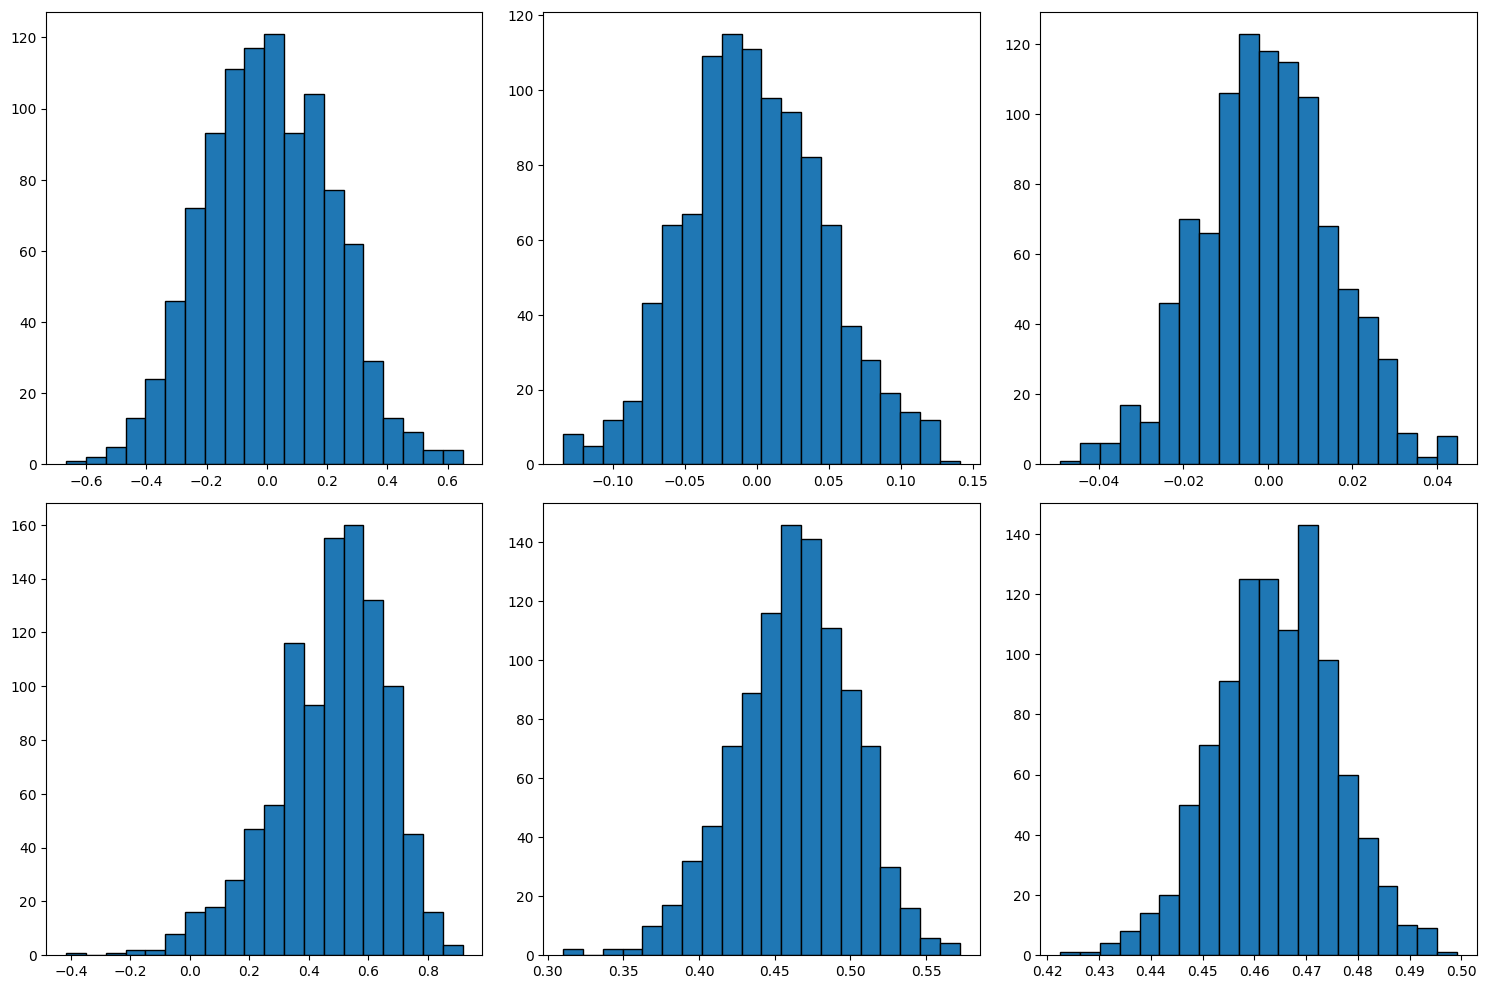

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loop through combinations and plot
for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        if (i == 0):
            if (j == 0):
                ax.hist(U_syms1, bins=20, edgecolor='black')
            if (j == 1):
                ax.hist(U_syms2, bins=20, edgecolor='black')
            if (j == 2):
                ax.hist(U_syms3, bins=20, edgecolor='black')
        if (i == 1):
            if (j == 0):
                ax.hist(U_skews1, bins=20, edgecolor='black')
            if (j == 1):
                ax.hist(U_skews2, bins=20, edgecolor='black')
            if (j == 2):
                ax.hist(U_skews3, bins=20, edgecolor='black')
            
plt.tight_layout()

# Sample means and variances

In [17]:
print(f"Sample Variance for n = 10 skew: {np.var(U_skews1, ddof = 1)}")
print(f"Sample Variance for n = 100 skew: {np.var(U_skews2, ddof = 1)}")
print(f"Sample Variance for n = 1000 skew: {np.var(U_skews3, ddof = 1)}")

Sample Variance for n = 10 skew: 0.034830601434768106
Sample Variance for n = 100 skew: 0.0014855960404154065
Sample Variance for n = 1000 skew: 0.00013207369507370573


In [18]:
print(f"Sample mean for n = 10 skew: {np.mean(U_skews1)}")
print(f"Sample mean for n = 100 skew: {np.mean(U_skews2)}")
print(f"Sample mean for n = 1000 skew: {np.mean(U_skews3)}")

Sample mean for n = 10 skew: 0.4655833333333333
Sample mean for n = 100 skew: 0.46273205936920225
Sample mean for n = 1000 skew: 0.464301032876564


In [19]:
print(f"Sample Variance for n = 10 sym: {np.var(U_syms1, ddof = 1)}")
print(f"Sample Variance for n = 100 sym: {np.var(U_syms2, ddof = 1)}")
print(f"Sample Variance for n = 1000 sym: {np.var(U_syms3, ddof = 1)}")

Sample Variance for n = 10 sym: 0.04439536175063953
Sample Variance for n = 100 sym: 0.0023690239871439864
Sample Variance for n = 1000 sym: 0.00024058576696325


In [20]:
print(f"Sample mean for n = 10 sym: {np.mean(U_syms1)}")
print(f"Sample mean for n = 100 sym: {np.mean(U_syms2)}")
print(f"Sample mean for n = 1000 sym: {np.mean(U_syms3)}")

Sample mean for n = 10 sym: 0.004816666666666666
Sample mean for n = 100 sym: -0.0005728385899814476
Sample mean for n = 1000 sym: -0.00023545405525766266


# Theoretical counterparts of the sample means and variances

The population mean for the symmetric distribution case is exactly equal to 0.

In [6]:
N = 10**8
X = np.random.chisquare(1, N)
Y = np.random.chisquare(1, N)
Z = np.random.chisquare(1, N)

# Calculating the expectation for the Chi-squared distributrion with degrees of freedom 1 monte carlo simulation
Prob_greater = np.mean(X + Y - 2 * Z > 0)
Prob_smaller = np.mean(X + Y - 2 * Z < 0)

# The multiplication by 3 is to adjust for my use of a differently scaled U-statistic
print(f"The theoretical mean for the skewed distribution is: {3 * (Prob_greater - Prob_smaller)}")

The theoretical mean for the skewed distribution is: 0.46433448


In [81]:
# Integration approach to calculating the probability
# -2Z has a - Gamma(1/2, 1/4) distribution
# X + Y has a Gamma(1, 1/2) distribution, which is equivalent to a chi-squared degrees of freedom 2 distribution
# Then I just use the convolution formula from probability theory and scipy's numerical integration package

def f_U(u):
    return 0.5 * np.exp(-0.5 * u) if u >= 0 else 0

def f_V(v):
    if v <= 0:
        return (0.5 / np.sqrt(np.pi)) * (-v)**(-0.5) * np.exp(v / 4)
    else:
        return 0

# Convolution formula for the sum of two random variables that are independent
def f_Z(z):
    def integrand(v):
        return f_U(z - v) * f_V(v)
    val, _ = quad(integrand, -np.inf, np.inf)
    return val

result, _ = quad(f_Z, 0, np.inf)
result_2, _ = quad(f_Z, -np.inf, 0)

/var/folders/lp/2803clqx0pl99g482vk3dknc0000gn/T/ipykernel_1853/449862887.py:19: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(integrand, -np.inf, np.inf)
/var/folders/lp/2803clqx0pl99g482vk3dknc0000gn/T/ipykernel_1853/449862887.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result_2, _ = quad(f_Z, -np.inf, 0)


In [82]:
print(f"The theoretical mean for the skewed distribution approximately equals: {3 * (result - result_2)}")

The theoretical mean for the skewed distribution approximately equals: 0.46445888261361845


In [78]:
# This was to ensure that the above warnings did not lead to any numerical precision loss

def f_U(u):
    # PDF of chi2_2
    return 0.5 * np.exp(-u / 2) if u >= 0 else 0

def f_V(v):
    # PDF of 2 * chi2_1
    if v > 0:
        return (1 / np.sqrt(4 * np.pi * v)) * np.exp(-v / 4)
    else:
        return 0

# Convolution formula for the sum of two random variables that are independent
def f_W(w):
    lower_limit = max(0, -w)
    def integrand(v):
        return f_U(w + v) * f_V(v)
    val, _ = quad(integrand, lower_limit, np.inf)
    return val

def prob_W_greater_than_0():
    val, _ = quad(f_W, 0, np.inf)
    return val

result = 2 * prob_W_greater_than_0() - 1

# The scaling by 3 is to adjust for my version of the U-statistic being slightly different
print(f"The theoretical mean for the skewed distribution approximately equals: {3 * result}")

The theoretical mean for the skewed distribution approximately equals: 0.4641015900254928


# Testing for skew in the one factor model

In [44]:
# U-Statistic is defined as follows for a triplet of draws X, Y, and Z:
# f(X, Y, Z) = sgn(X + Y - 2Z) + sgn(X + Z - 2Y) + sgn(Y + Z - 2X)

# This function will calculate the triples test for skewness provided a triplet of data points
# The argument triplet is a 3x1 vector of sampled variables
def triples_test(data):
    N = len(data)
    triplet = np.array(list(combinations(data, 3)))
    X, Y, Z = triplet[:, 0], triplet[:, 1], triplet[:, 2]
    scalar = (1 / comb(N, 3, exact = True))
    return scalar * np.sum(np.sign(X + Y - 2*Z) + np.sign(X + Z - 2*Y) + np.sign(Y + Z - 2*X))


U_stats_100 = []
U_stats_1000 = []
U_stats_10000 = []

In [51]:
for i in range(999):
    # Originally simulate the 10000 betas from a normal distribution with mean 1 and variance 0.25
    betas = np.random.normal(1, 0.25, 10000)
    
    p_vector = [100, 1000, 10000]
    
    #This is the number of observations/simulations that will be done for this example
    n = 100
    
    # This is just the variance of the factor that I chose. For the purposes of simulation, this is fine.
    # In real data, find this number via doing PCA.
    variance = 25
    
    for p in p_vector:
        # Since the factor and specific returns are jointly normal with dimension p + 1 and are independent
        # their corresponding marginal distributions are also normally distributed
        # For the purposes of simultation, simulating from the marginal distributions rather than the joint MVN distribution
        # is a lot more computationally feasible
        # Simulation from the MVN has O(p^3) runtime
    
        betas_p = betas[:p]
        facs = np.random.normal(10, variance, n)
        specifics = np.random.normal(0, 1, (p, n))
    
        fac_returns = (np.outer(betas_p, facs) + specifics)
        sum_returns = 1/p * (np.sum(fac_returns, axis = 0))**2
        U_stat = triples_test(sum_returns)
        if (p == 100):
            U_stats_100.append(U_stat)
        if (p == 1000):
            U_stats_1000.append(U_stat)
        if (p == 10000):
            U_stats_10000.append(U_stat)

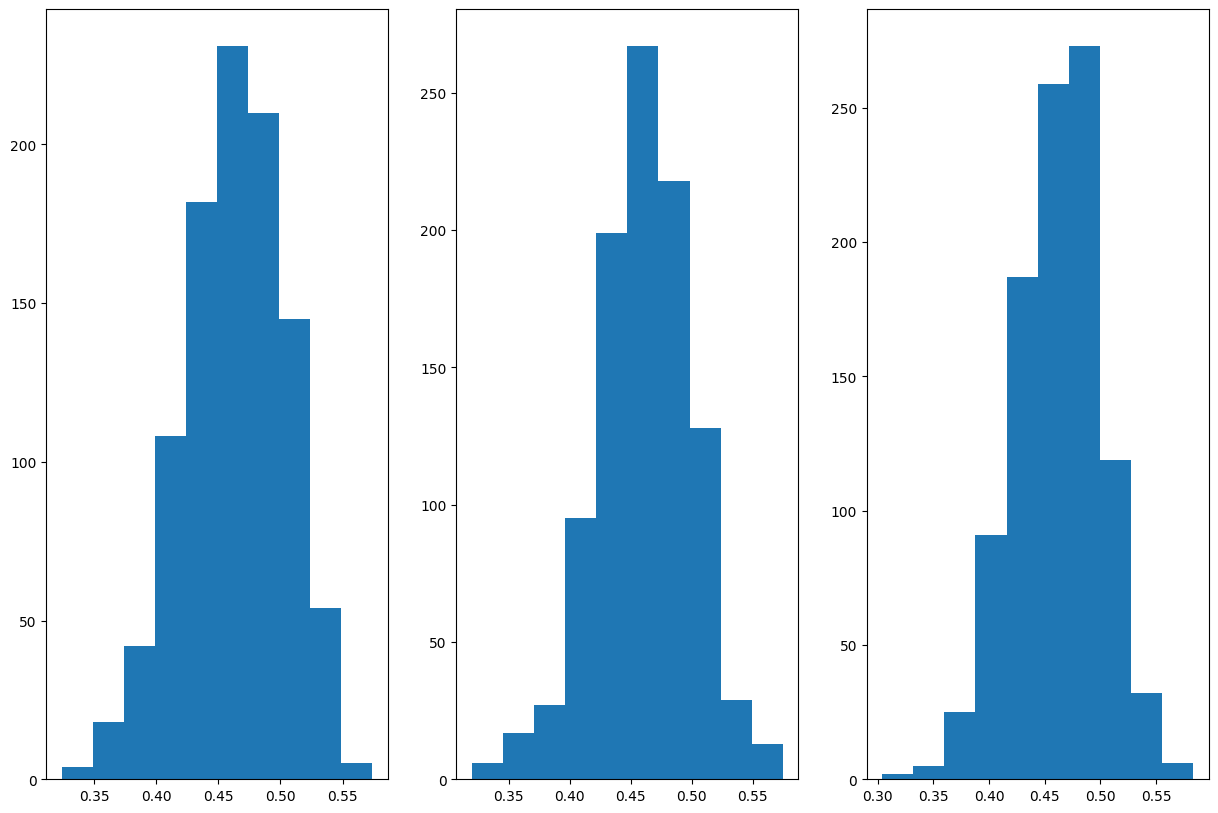

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

axes[0].hist(U_stats_100)

axes[1].hist(U_stats_1000)

axes[2].hist(U_stats_10000);